## Imports

In [266]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.preprocessing import binarize
from numpngw import write_png

## Load data from parsed

In [2]:
pipes_df = pd.read_csv('dataset_df/pipes_df.csv')
spills_df = pd.read_csv('dataset_df/spills_df.csv')

In [3]:
pipes_df.head()

,time,lon_start,lat_start,lon_end,lat_end,name
0,2021-06-04 06:42:19+00:00,73.033226,60.588367,73.044554,60.594281,0_2021_06_04_06_42_19.npy
1,2021-06-09 06:42:19+00:00,73.033226,60.588367,73.044554,60.594281,1_2021_06_09_06_42_19.npy
2,2021-06-11 06:32:21+00:00,73.033226,60.588367,73.044554,60.594281,2_2021_06_11_06_32_21.npy
3,2021-06-14 06:42:20+00:00,73.033226,60.588367,73.044554,60.594281,3_2021_06_14_06_42_20.npy
4,2021-06-26 06:32:22+00:00,73.033226,60.588367,73.044554,60.594281,4_2021_06_26_06_32_22.npy


In [4]:
new_cols = ['band_' + str(i) for i in range(1, 20)]

for col in new_cols:
    pipes_df[f'{col}'] = 0.0
    spills_df[f'{col}'] = 0.0

In [6]:
folder = 'pipes_frames'
for i in range(len(pipes_df)):
    np_array = np.mean(np.load('dataset/' + folder + '/' + pipes_df.iloc[i, 5]), axis= (0, 1))
    for j in range(19):
        pipes_df.iloc[i, 6+j] = np_array[j]

In [7]:
len(pipes_df)

23320

In [9]:
folder = 'spills_frames'
for i in range(len(spills_df)):
    np_array = np.mean(np.load('dataset/' + folder + '/' + spills_df.iloc[i, 5]), axis= (0, 1))
    for j in range(19):
        spills_df.iloc[i, 6+j] = np_array[j]

In [10]:
print(len(pipes_df))
print(len(spills_df))

23320
55429


In [52]:
def plot_loss(history):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.ylim([0, 1])
    plt.xlabel('Epoch')
    plt.ylabel('Error [ACC]')
    plt.legend()
    plt.grid(True)

## Prepare train df

In [34]:
pipes_df['y'] = 0
spills_df['y'] = 1

In [35]:
train_df = pd.concat([pipes_df, spills_df.sample(23320)])

In [41]:
train_df.sample(5)

,time,lon_start,lat_start,lon_end,lat_end,name,band_1,band_2,band_3,band_4,...,band_11,band_12,band_13,band_14,band_15,band_16,band_17,band_18,band_19,y
21917,2019-03-15 07:48:44+00:00,61.247597,64.893078,61.260737,64.898977,21917_2019_03_15_07_48_44.npy,3.386096,3.493754,3.371102,3.466945,...,0.764944,0.664413,0.0002,4.815186,0.000000,20.443848,1.0,10.747070,40.152588,1
20890,2021-07-27 06:53:16+00:00,65.646453,57.895839,65.657662,57.901356,20890_2021_07_27_06_53_16.npy,2.153678,2.271948,2.313056,2.116725,...,3.257207,2.580756,0.0001,36.609619,1.000000,191.221436,1.0,6.675781,0.000000,0
15523,2021-06-05 07:02:19+00:00,69.809323,60.684492,69.821186,60.690166,15523_2021_06_05_07_02_19.npy,0.569887,0.742056,1.085752,1.214080,...,2.882127,1.954815,0.0002,0.000000,0.000000,15.583984,1.0,4.473145,0.000000,0
20242,2021-06-08 07:12:48+00:00,64.533311,60.360872,64.545179,60.366482,20242_2021_06_08_07_12_48.npy,4.787566,4.704816,4.554432,4.440856,...,4.701025,4.317624,0.0001,95.100586,1.000000,247.036133,1.0,8.880127,0.000000,0
17959,2021-06-25 07:02:59+00:00,66.006420,59.186711,66.017104,59.192708,17959_2021_06_25_07_02_59.npy,1.987629,1.976534,1.911212,1.743135,...,1.976967,1.668563,0.0001,36.727539,0.926758,129.095703,1.0,6.386230,0.000000,0


In [16]:
train_df = train_df.drop(columns=['time', 'lon_start', 'lat_start', 'lon_end', 'lat_end', 'name'])

In [17]:
# train_df['ndvi'] = (train_df['band_8'] - train_df['band_4'])/(train_df['band_8'] + train_df['band_4'])

In [18]:
train_df = train_df.dropna()

In [19]:
numeric_list = train_df.select_dtypes(include=[np.number]).columns
train_df[numeric_list] = train_df[numeric_list].astype(np.float32)

In [20]:
train_df.dtypes

band_1     float32
band_2     float32
band_3     float32
band_4     float32
band_5     float32
band_6     float32
band_7     float32
band_8     float32
band_9     float32
band_10    float32
band_11    float32
band_12    float32
band_13    float32
band_14    float32
band_15    float32
band_16    float32
band_17    float32
band_18    float32
band_19    float32
y          float32
dtype: object

In [21]:
train_dataset = train_df.sample(frac=0.9, random_state=0)
test_dataset = train_df.drop(train_dataset.index)

In [22]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('y')
test_labels = test_features.pop('y')

In [23]:
# normalizer = tf.keras.layers.experimental.preprocessing.Normalization(axis=-1)

In [24]:
# normalizer.adapt(np.array(train_features))

In [25]:
# normalizer

In [26]:
# first = np.array(train_features[:1])

# with np.printoptions(precision=2, suppress=True):
#     print('First example:', first)
#     print()
#     print('Normalized:', normalizer(first).numpy())

## Reseach channels in regression for mean_frame

In [258]:
model = tf.keras.Sequential([
    layers.Dense(units=1, activation=tf.nn.sigmoid)
])

In [259]:
model.predict(train_features[:10])

array([[2.6308504e-04],
       [9.0063568e-06],
       [9.9908638e-01],
       [9.9085683e-01],
       [1.5121831e-01],
       [9.9863154e-01],
       [1.0000000e+00],
       [1.4828838e-01],
       [8.1063437e-01],
       [4.3032602e-03]], dtype=float32)

In [260]:
model.layers[0].kernel

<tf.Variable 'dense_5/kernel:0' shape=(19, 1) dtype=float32, numpy=
array([[-0.4912897 ],
       [ 0.01057392],
       [-0.48199293],
       [ 0.47272098],
       [-0.13405198],
       [ 0.4812181 ],
       [ 0.45060003],
       [ 0.36219794],
       [ 0.326989  ],
       [-0.1107915 ],
       [ 0.15657556],
       [ 0.2742781 ],
       [-0.5048888 ],
       [ 0.21617621],
       [-0.30498922],
       [-0.27531093],
       [-0.09397539],
       [-0.27519003],
       [ 0.21776426]], dtype=float32)>

In [261]:
model.compile(optimizer='sgd',
loss='binary_crossentropy',
metrics=['accuracy'])

In [262]:
history = model.fit(
    train_features,
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

In [204]:
result = pd.DataFrame(np.array(model.layers[1].kernel))
result['index'] = [i for i in range(1, 21)]
result = result.set_index('index')
result

,0
index,
1,-1.980254
2,-0.642318
3,-0.733566
4,0.775070
5,2.279209
6,0.714435
7,0.381890
8,-0.149938
9,-0.131994


B01 Coastal aerosol - 1.72,
B04 Red - 1.494937,
B05 Vegetation red edge - 2.550103,
B08 NIR - -1.136251
B09 Water vapour - -1.161327
B10 SWIR Cirrus - -1.052148
B11 SWIR - 2.098709
CLP - -1.277699

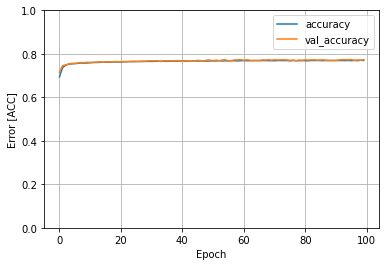

In [132]:
plot_loss(history)

## CNN for mean_frame

In [27]:
def build_and_compile_model():
    model = keras.Sequential([
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1, activation=tf.nn.sigmoid)
    ])

    model.compile(optimizer='sgd',
        loss='binary_crossentropy',
        metrics=['accuracy'])
    return model

In [28]:
dnn_model = build_and_compile_model()

In [54]:
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=1, epochs=1)

1050/1050 [==============================] - 4s 4ms/step - loss: 0.4123 - accuracy: 0.8117 - val_loss: 0.4121 - val_accuracy: 0.8101


## Apply mean_frame clasification to each pixel

load 50 frames

In [ ]:
write_png 

In [274]:
folder = 'pipes_frames'
np_pipe_frames = None
for i in range(0, 200):
    np_array = np.load('dataset/' + folder + '/' + pipes_df.iloc[i, 5])[None, ...]
    np_pipe_frames = (np.vstack((np_pipe_frames, np_array)) if (np_pipe_frames is not None) else np_array)


In [276]:
folder = 'spills_frames'
np_spills_frames = None
for i in range(0, 200):
    np_array = np.load('dataset/' + folder + '/' + spills_df.iloc[i, 5])[None, ...]
    np_spills_frames = (np.vstack((np_spills_frames, np_array)) if (np_spills_frames is not None) else np_array)

In [291]:
for i in range(len(np_pipe_frames)):
    test_frame = pd.DataFrame(np_pipe_frames[i].reshape((4096, 19)), columns = ['band_1', 'band_2', 'band_3', 'band_4', 'band_5', 'band_6', 'band_7',
       'band_8', 'band_9', 'band_10', 'band_11', 'band_12', 'band_13',
       'band_14', 'band_15', 'band_16', 'band_17', 'band_18', 'band_19'])
    img_frame = test_frame[[ 'band_2', 'band_3', 'band_4']]
    img_frame = np.array(img_frame).reshape((64, 64, 3))
    max_element = np.amax(img_frame)
    img_frame = (img_frame/max_element * 255).astype('uint8')
    write_png('pipes_images/' + pipes_df.iloc[i, 5] + '.png', img_frame)
    

In [277]:
for i in range(len(np_spills_frames)):
    test_frame = pd.DataFrame(np_spills_frames[i].reshape((4096, 19)), columns = ['band_1', 'band_2', 'band_3', 'band_4', 'band_5', 'band_6', 'band_7',
       'band_8', 'band_9', 'band_10', 'band_11', 'band_12', 'band_13',
       'band_14', 'band_15', 'band_16', 'band_17', 'band_18', 'band_19'])
    img_frame = test_frame[[ 'band_2', 'band_3', 'band_4']]

    img_frame = np.array(img_frame).reshape((64, 64, 3))
    max_element = np.amax(img_frame)
    img_frame = (img_frame/max_element * 255).astype('uint8')
    write_png('spills_images/' + spills_df.iloc[i, 5] + '.png', img_frame)

<ipython-input-277-3380c113c329>:8: RuntimeWarning: invalid value encountered in true_divide
  img_frame = (img_frame/max_element * 255).astype('uint8')


In [835]:
FRAME = 6
test_frame = pd.DataFrame(np_spills_frames[FRAME].reshape((4096, 19)), columns = ['band_1', 'band_2', 'band_3', 'band_4', 'band_5', 'band_6', 'band_7',
       'band_8', 'band_9', 'band_10', 'band_11', 'band_12', 'band_13',
       'band_14', 'band_15', 'band_16', 'band_17', 'band_18', 'band_19'])
img_frame = test_frame[[ 'band_2', 'band_3', 'band_4']]
img_frame = np.array(img_frame).reshape((64, 64, 3))
max_element = np.amax(img_frame)
img_frame = (img_frame/max_element * 255).astype(int)
# b5_frame = (test_frame['band_8'] - test_frame['band_4'])/(test_frame['band_8'] + test_frame['band_4'])
b5_frame = (test_frame['band_8'] - test_frame['band_4'])/(test_frame['band_8'] + test_frame['band_4'])
# b5_frame = test_frame['band_5']
# b5_frame = test_frame['band_11']
b5_frame = np.array(b5_frame).reshape((64, 64, 1))
print(max_element)
max_element = 3 #np.amax(b5_frame)

b5_frame = (b5_frame/max_element * 255).astype('uint8')

3.288


In [836]:
b5_prediction = (-b5_frame+255)/255

In [837]:
prediction_labels = np.ravel(binarize(b5_prediction.reshape(1,-1), 0.7))

C:\Users\Dmitry\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass threshold=0.7 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [838]:
prediction_mask = prediction_labels.reshape((64, 64))

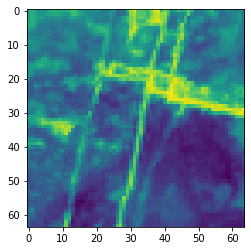

In [839]:
plt.imshow(b5_prediction)

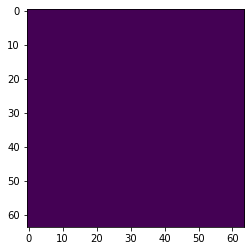

In [840]:
plt.imshow(prediction_mask)

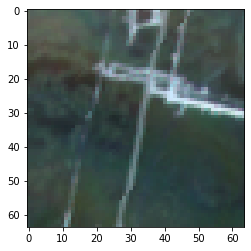

In [841]:
plt.imshow(img_frame)

In [783]:
prediction = dnn_model.predict(test_frame).flatten()

In [698]:
prediction_labels = np.ravel(binarize(prediction.reshape(1,-1), 0.7))

C:\Users\Dmitry\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass threshold=0.7 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [699]:
prediction_mask = prediction_labels.reshape((64, 64))

In [700]:
import matplotlib.pyplot as plt

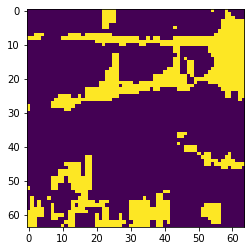

In [701]:
plt.imshow(prediction_mask)

In [256]:
for frame_index in range(len(np_pipe_frames)):
            label = dnn_model.predict(pixel).flatten()

ValueError: in user code:

    C:\Users\Dmitry\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1569 predict_function  *
        return step_function(self, iterator)
    C:\Users\Dmitry\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1559 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\Dmitry\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\Dmitry\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\Dmitry\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\Dmitry\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1552 run_step  **
        outputs = model.predict_step(data)
    C:\Users\Dmitry\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1525 predict_step
        return self(x, training=False)
    C:\Users\Dmitry\anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:1013 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\Dmitry\anaconda3\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:251 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer sequential is incompatible with the layer: expected axis -1 of input shape to have value 19 but received input with shape (None, 1)


In [66]:
np.array(train_features.iloc[1, :])

array([3.0027112e-01, 2.7419907e-01, 3.3966133e-01, 2.6532409e-01,
       4.6768442e-01, 8.8107687e-01, 9.9554050e-01, 9.9142230e-01,
       1.0795391e+00, 1.1276207e+00, 5.0026357e-01, 3.2289463e-01,
       9.9995741e-05, 1.0708008e+00, 0.0000000e+00, 4.4132324e+01,
       1.0000000e+00, 3.5827637e+00, 0.0000000e+00], dtype=float32)

In [68]:
dnn_model.predict(test_features)

array([[0.05173795],
       [0.6560834 ],
       [0.81587243],
       ...,
       [0.95216763],
       [0.2752726 ],
       [0.78592205]], dtype=float32)

In [ ]:
frame = pd.DataFrame

In [69]:
test_features

,band_1,band_2,band_3,band_4,band_5,band_6,band_7,band_8,band_9,band_10,band_11,band_12,band_13,band_14,band_15,band_16,band_17,band_18,band_19
10,0.104064,0.199570,0.335654,0.189727,0.538912,1.853454,2.233041,2.321351,2.387251,2.399954,1.052174,0.474047,0.0001,0.000000,0.000000,9.046631,1.0,4.000000,0.000000
43,0.278742,0.349475,0.556695,0.434873,1.112376,2.293653,2.686766,2.767281,2.974099,2.961491,1.442046,0.747087,0.0002,0.035400,0.000000,12.009766,1.0,4.000000,0.000000
52,0.211107,0.301669,0.524446,0.436277,1.103926,2.309107,2.725102,2.919625,3.062158,3.094532,1.606576,0.825225,0.0001,0.000000,0.000000,5.662842,1.0,4.000000,0.000000
75,4.581708,4.054855,3.399466,2.670751,2.871751,3.560759,3.784239,3.687207,3.737922,5.905019,1.650480,0.789598,0.0005,46.801758,1.000000,231.391602,1.0,8.000000,0.000000
77,0.184656,0.187808,0.391007,0.215773,0.693480,2.382785,2.813554,2.978636,3.037577,3.054376,1.335033,0.603744,0.0001,0.000000,0.000000,7.685547,1.0,4.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32009,0.482596,0.529474,0.343840,0.141850,0.110897,0.065065,0.066262,0.054609,0.042448,0.034005,0.010528,0.008573,0.0001,0.000000,0.000000,0.000000,1.0,9.198242,0.000000
337,1.925350,2.205425,2.382690,2.362998,2.834382,3.456944,3.558128,3.784111,3.641893,3.824693,0.894338,0.691150,0.0002,12.791260,0.000000,33.531250,1.0,9.517334,11.965088
34643,4.193738,4.156022,4.268947,4.192471,4.674706,5.066753,4.806560,4.850052,4.548418,4.656536,0.369636,0.236611,0.0002,0.038086,0.000000,5.693115,1.0,10.997070,73.755859
49988,2.060263,2.400486,2.311805,2.328529,2.657175,2.844610,2.923580,3.327961,3.027161,3.687274,2.784246,2.416947,0.0002,40.884521,0.702393,114.761719,1.0,6.687500,0.000000


In [73]:
test_features.columns

Index(['band_1', 'band_2', 'band_3', 'band_4', 'band_5', 'band_6', 'band_7',
       'band_8', 'band_9', 'band_10', 'band_11', 'band_12', 'band_13',
       'band_14', 'band_15', 'band_16', 'band_17', 'band_18', 'band_19'],
      dtype='object')